<a href="https://colab.research.google.com/github/JimenaBaripatti/FeatureEngineering/blob/main/Fire_High_Cardinality_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**To review/impute/FE Categorical variables with high cardinality

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# setting up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import statistics
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
import math
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from textblob import TextBlob

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline


# Setting working directory
#os.chdir("/content/drive/MyDrive/Colab Notebooks/Data/")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [3]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 481 kB/s 


# Functions

In [4]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [5]:
# explore different variables
def exploration_cat(c):

  print('---------------------------------------')

  print('variable name:', c, '\n')
  print('number of categories: ' ,df[c].unique().shape[0], '\n')
  print(df[c].value_counts(normalize=True, dropna=False))

  print('---------------------------------------')

In [6]:
# plot categorical variables
def plot_cat(c):
  plt.figure(figsize=(20,7))
  cat_count=df[c].value_counts(normalize=True, dropna=False)
  fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
  plt.title('Frequency Distribution of ' + str(c))
  plt.xlabel('% occurences', fontsize=12)
  #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
  plt.show()


In [7]:
# frequency encoding
def freq_encode(c):
  freq_count=df[c].value_counts(normalize=True).to_dict()
  c_imputed=str(c)+'_imputed'
  df[c_imputed]=df[c].map(freq_count)
  return df

In [8]:
# Impute with the most frequent category
def impute_frequent (c):
  top_cat=df[c].value_counts().nlargest(1).index[0]
  index_to_impute=df[df[c].isnull()].index
  df.at[index_to_impute,c]=top_cat
  return df

In [9]:
# use WOE for categorical variables - feature creation based on the output woe value
def woe_encoder(c,target):
  from category_encoders import WOEEncoder
  x = WOEEncoder()
  x.fit(df[c],df[target])
  df[str(c)+'_woe']=x.transform(df[c],df[target])
  return df

# Load Complete Fire Data


In [10]:
df=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/fire_incident_station_weather_demo_combined.csv', index_col=[0])

In [11]:
df.shape

(17536, 106)

In [11]:
df.head(2)

,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Numberinc_,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,Latitude,Longitude,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male
0,1946929,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2018-02-25 02:12:00,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:15:40,999 - Undetermined,F18020956,441,1.0,Vehicle Fire,Dixon Rd / 427 N Dixon Ramp,2018-02-25 02:38:31,NaN,47 - Vehicle,1 - Extinguished by fire department,1,4,99 - Undetermined,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, spreading outdoor fire)",2018-02-25 02:04:29,2018-02-25 02:10:11,0,17,80,FIRE STATION 441,947 MARTIN GROVE RD,6044964,22707,6044958,REGULAR,947,Martin Grove Rd,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 441,NaN,NaN,NaN,NaN,Etobicoke North (1),Etobicoke,1959089,"{u'type': u'Point', u'coordinates': (-79.5719196489, 43.6949604664)}",-79.571920,43.694960,441,0,13705.717515,2018-02-25 00:00:00,6,1,2018,2,5.7,25,25,2,2,28.333,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020956,2018-02-25 02:04:29,43.686558,-79.599419,M9W 5N4,M9W,0,1411.27,0.066034,0.175848,39.6,38.3,0.490844
1,1946930,"75 - Trash, rubbish area (outside)",NaN,NaN,0,0,50.0,NaN,NaN,2018-02-25 02:29:42,NaN,01 - Fire,NaN,NaN,NaN,2018-02-25 02:32:24,999 - Undetermined,F18020969,116,18.0,Fire - Grass/Rubbish,Sheppard Ave E / Clairtrell Rd,2018-02-25 02:35:58,NaN,97 - Other,1 - Extinguished by fire department,1,4,03 - Suspected Vandalism,"896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 - Fire with no evidence from street,2018-02-25 02:24:43,2018-02-25 02:29:31,0,46,6,FIRE STATION 116,255 ESTHER SHINER BLVD,8731578,1464220,30005958,REGULAR,255,Esther Shiner Blvd,NaN,Fire Station,"Structure, Structure Entrance",484876.0,Fire Station 116,NaN,NaN,NaN,NaN,Don Valley North (17),North York,2607109,"{u'type': u'Point', u'coordinates': (-79.3650636555, 43.7691459436)}",-79.365064,43.769146,116,0,13691.564674,2018-02-25 00:00:00,6,1,2018,2,4.8,25,25,2,2,6.450,1,Late Night,0,0,0,0,2018-02-25,0.96,0.77,5.1,-3.415,71.47,18.39,F18020969,2018-02-25 02:24:43,43.766135,-79.390039,M2N 3B1,M2N,0,7581.15,0.036021,0.682775,39.9,37.0,0.469236


In [12]:
#drop unwanted columns
my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']

fire_not_needed_cols = ['_id_x','_id_y','Exposures']
Demographics_not_needed_cols = ['fsa_imputed','location']                        
station_not_needed_cols=['ID', 'ADDRESS_ID_LINK', 'X','Y', 'LATITUDE', 'LONGITUDE','POSTAL_CODE','MAINT_STAGE','GENERAL_USE','CLASS_FAMILY_DESC', 'INCIDENT_PERIOD_CAT']
weather_not_needed_cols=['date', 'Incident_Numberdemo','TFS_Alarm_Timedemo']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols + Demographics_not_needed_cols + fire_not_needed_cols + station_not_needed_cols + weather_not_needed_cols
df.drop(columns=drop_columns, axis=1,inplace=True)

In [13]:
find_diff_type_var(df)

(Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
        'Extent_Of_Fire', 'Final_Incident_Type',
        'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
        'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
        'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
        'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
        'Smoke_Alarm_at_Fire_Origin',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
        'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
        'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
        'Smoke_Spread', 'Sprinkler_System_Operation',
        'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'FSA'],
       dtype='object'),
 Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
        'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
        'Number_of_responding_apparatus', 'Number_of_responding_personnel',
      

# Imputation 


*   Property_Use: only 1 missing
*   Level_of_Origin: impute as '999'
*   'Ignition_Source','Material_First_Ignited','Possible_Cause': impute with the most frequent




In [14]:
# Impute null categorical variables
# only one missing for 'Property_Use'
df.at[df[df['Property_Use'].isnull()].index,'Property_Use']='Other'
# Level of Origin
#impute with '999'
df.at[df[df['Level_Of_Origin'].isnull()].index,'Level_Of_Origin']='999'

In [15]:
# Impute with the most frequent category
cols_to_impute=['Ignition_Source','Material_First_Ignited','Possible_Cause']
for col in cols_to_impute:
  df_test=impute_frequent(col)
print(df[cols_to_impute].isnull().sum())

Ignition_Source           0
Material_First_Ignited    0
Possible_Cause            0
dtype: int64


# Categorical variables overview

In [ ]:
cat_var = df.loc[:,df.dtypes == np.object].columns
n_cat = [df[x].unique().shape[0] for x in cat_var]
n_missing=[df[x].isnull().sum() for x in cat_var]

In [ ]:
cat_var_summary=pd.DataFrame(data=zip(n_cat,n_missing),index=cat_var, columns=['number of categories','number of missing records']).sort_values(by=['number of categories'], ascending=False)

In [ ]:
high_cat=cat_var_summary[cat_var_summary['number of categories']>=20]
med_cat=cat_var_summary[(cat_var_summary['number of categories']>5) & (cat_var_summary['number of categories']<20)]
low_cat=cat_var_summary[cat_var_summary['number of categories']<=5]

In [ ]:
# Categorical variables with high cardinality
#FSA: impute with numerical % incident with casualty

In [ ]:
cat_var_id=['Incident_Numberinc_','FSA']
high_cat=[x for x in high_cat.index if x not in cat_var_id]

In [ ]:
cat_var_summary

,number of categories,number of missing records
Incident_Numberinc_,17536,0
Property_Use,284,0
Initial_CAD_Event_Type,115,0
FSA,96,0
Ignition_Source,84,0
Area_of_Origin,74,1913
Level_Of_Origin,59,0
Material_First_Ignited,54,0
Possible_Cause,24,0
Extent_Of_Fire,13,6322


In [ ]:
for c in high_cat:
  exploration_cat(c)

---------------------------------------
variable name: Property_Use 

number of categories:  284 

323 - Multi-Unit Dwelling - Over 12 Units                                        0.220632
301 - Detached Dwelling                                                          0.141766
901 - Automobile                                                                 0.082345
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.053718
302 - Semi-Detached Dwelling                                                     0.044138
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.042313
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                          0.034500
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.027030
902 - Small Truck (eg. pick-up, van, etc.)                                       0.020814
321 - Multi-Unit Dwelling - 2 to 6 Units                                         0.016423
3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


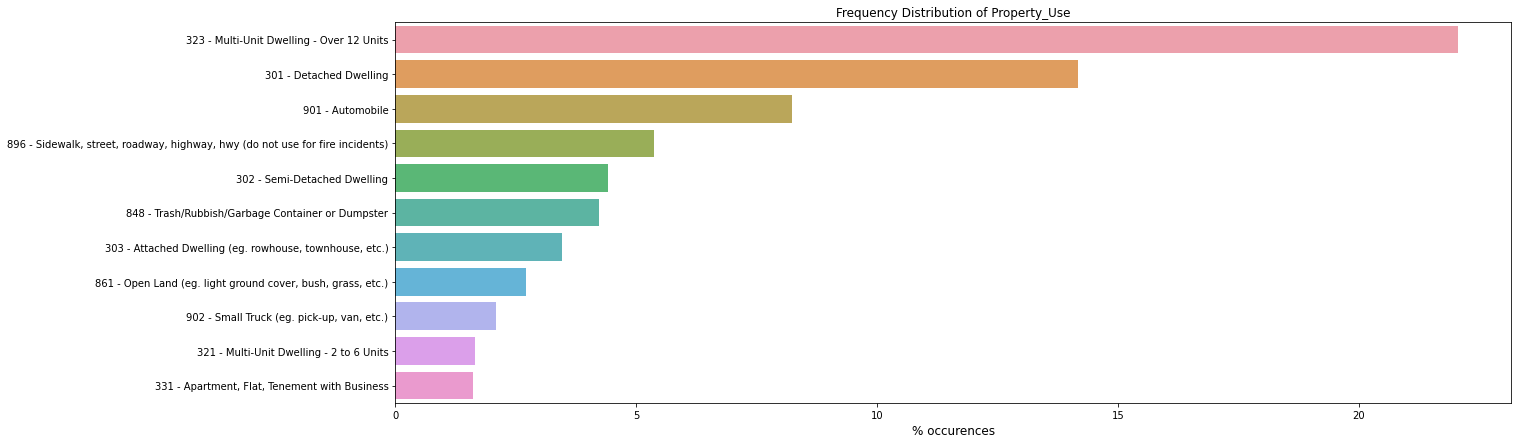

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


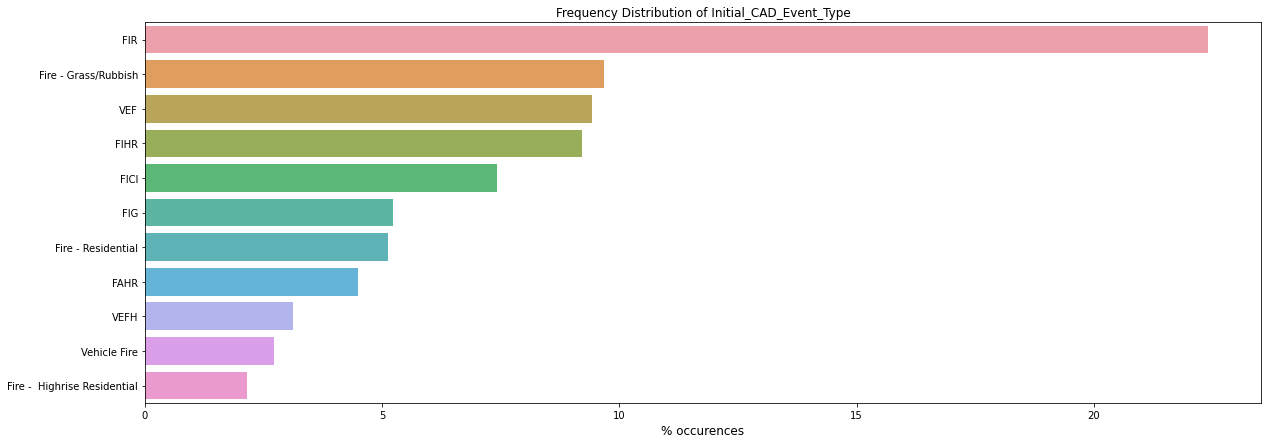

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


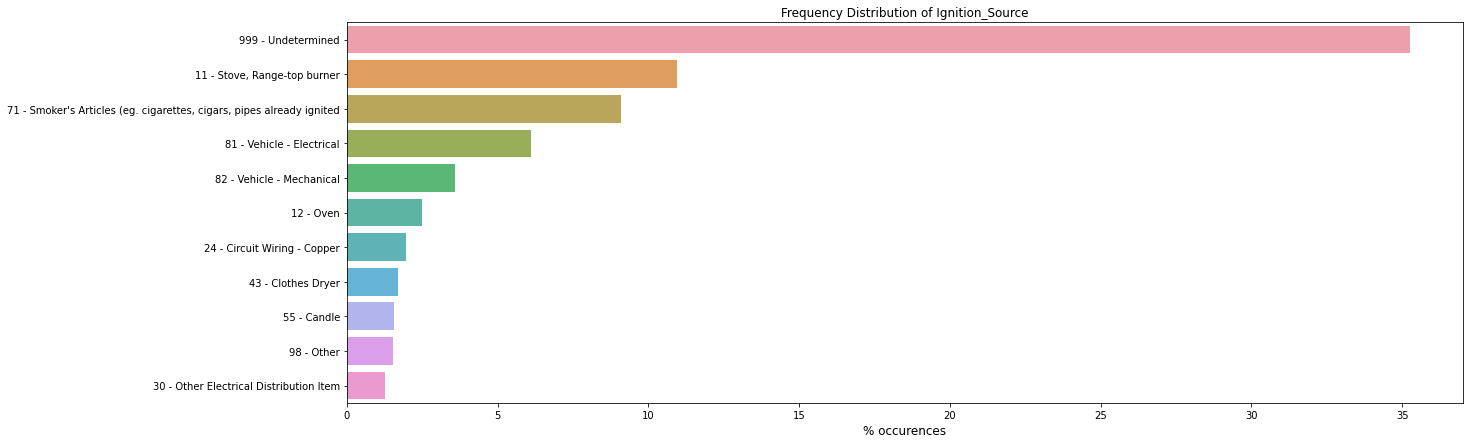

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


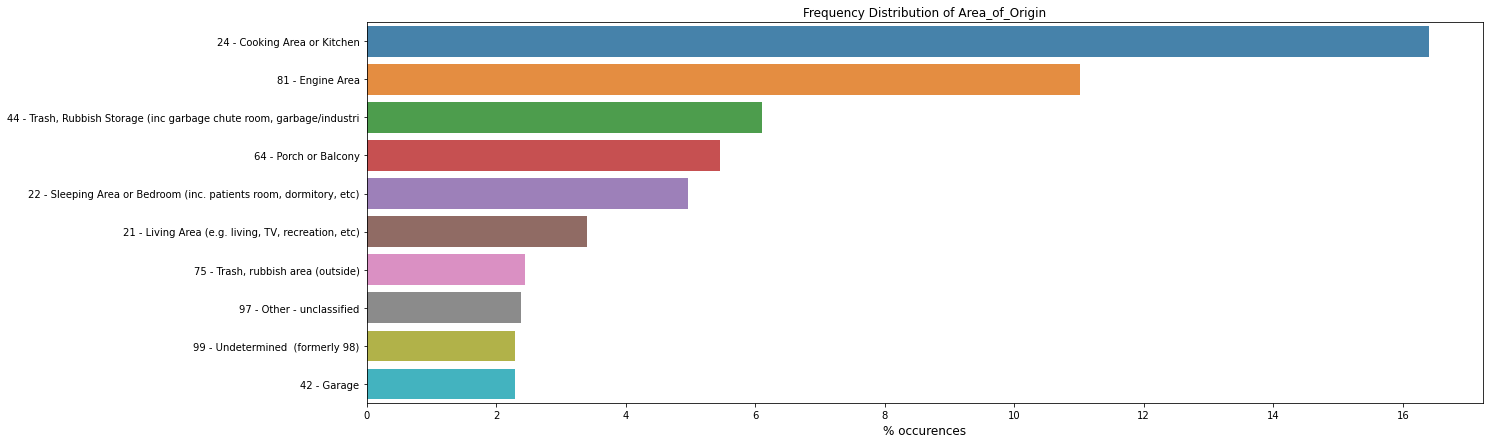

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


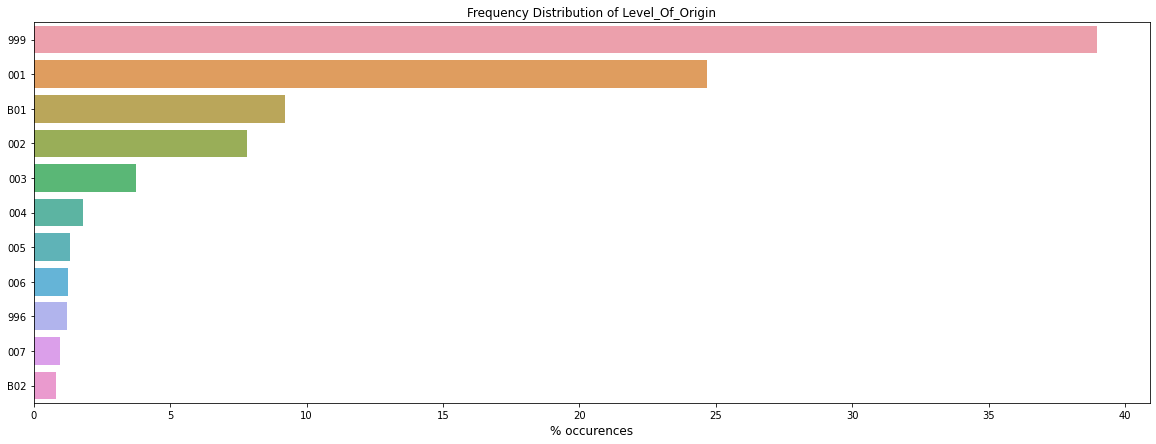

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


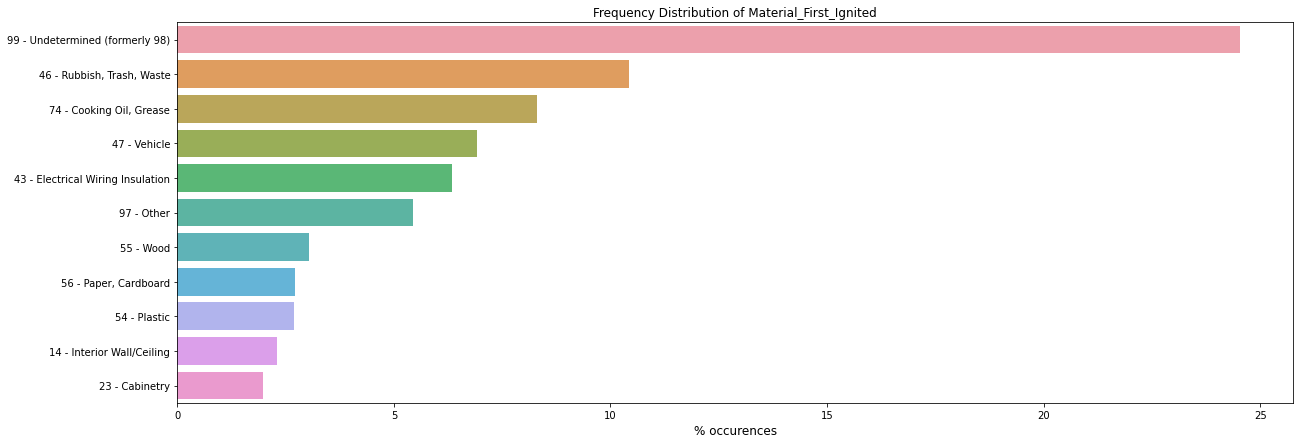

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


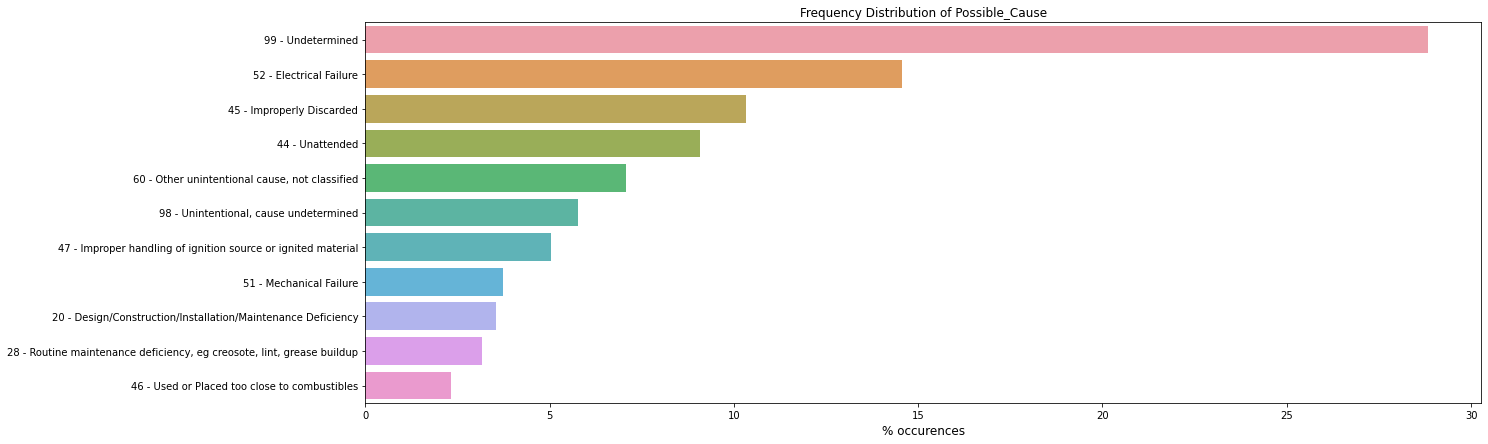

In [ ]:
for c in high_cat:
  plot_cat(c)

In [ ]:
med_cat=[x for x in med_cat.index if x not in cat_var_id]
for c in med_cat:
  exploration_cat(c)

---------------------------------------
variable name: Extent_Of_Fire 

number of categories:  13 

NaN                                                                                 0.360516
1 - Confined to object of origin                                                    0.292142
2 - Confined to part of room/area of origin                                         0.232892
3 - Spread to entire room of origin                                                 0.027429
4 - Spread beyond room of origin, same floor                                        0.026745
9 - Confined to roof/exterior structure                                             0.019503
7 - Spread to other floors, confined to building                                    0.015625
11 - Spread beyond building of origin, resulted in exposure fire(s)                 0.006843
8 - Entire Structure                                                                0.005646
99 - Undetermined                                              

### High Card: FSA frequency encoding

In [ ]:
#encode FSA with frequency (numerical)
df=freq_encode('FSA')

### High Card: Level of Origin binning


* 001-003 low_rise_level
* 004-012 mid_rise_level
* 012-100 high_rise_level
* 996 roof
* B - below_grade_level
* rest including NaN - other



In [ ]:
#Level_of_Origin: https://www.toronto.ca/ext/open_data/catalog/data_set_files/ofmcodes2009.pdf
LOO=df['Level_Of_Origin']

In [ ]:
LOO_imputed=[None]*len(LOO)
for i in range(len(LOO)):
  try: 
    #LOO_imputed[i]=int(LOO[i])
    if int(LOO[i])<=3:
      LOO_imputed[i]='low_rise_level'
    elif int(LOO[i])<=12:
      LOO_imputed[i]='mid_rise_level'
    elif int(LOO[i])<=100:
      LOO_imputed[i]='high_rise_level'
    elif int(LOO[i])==996:
      LOO_imputed[i]='roof'
    else:
      LOO_imputed[i]='other'
  except:
    LOO_imputed[i]='below_grade_level'
print(LOO_imputed[0:50])

['other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'other', 'other', 'low_rise_level', 'high_rise_level', 'low_rise_level', 'other', 'other', 'other', 'mid_rise_level', 'low_rise_level', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'other', 'other', 'other', 'other', 'other', 'low_rise_level', 'other', 'low_rise_level', 'mid_rise_level', 'other', 'other', 'mid_rise_level', 'other']


In [ ]:
df['LOO_imputed']=LOO_imputed

### High Card: Possible Cause


*   evaluate woe for each category
*   create bins based on woe



In [ ]:
df_test=woe_encoder('Possible_Cause','LABEL')

In [ ]:
df_test[['Possible_Cause','Possible_Cause_woe']].drop_duplicates().sort_values(by='Possible_Cause_woe')

,Possible_Cause,Possible_Cause_woe
13,"28 - Routine maintenance deficiency, eg creosote, lint, grease buildup",-1.421197
21,51 - Mechanical Failure,-1.358665
1,03 - Suspected Vandalism,-1.299777
106,49 - Improper Storage,-1.257930
947,73 - Natural Cause,-0.995566
6,20 - Design/Construction/Installation/Maintenance Deficiency,-0.823195
0,99 - Undetermined,-0.610312
58,01 - Suspected Arson,-0.546298
7,52 - Electrical Failure,-0.400887
48,45 - Improperly Discarded,-0.331906


In [ ]:
df_test=woe_encoder('Initial_CAD_Event_Type','LABEL')

In [ ]:
df_test[['Initial_CAD_Event_Type','Initial_CAD_Event_Type_woe']].drop_duplicates().sort_values(by='Initial_CAD_Event_Type_woe')

,Initial_CAD_Event_Type,Initial_CAD_Event_Type_woe
1,Fire - Grass/Rubbish,-3.526908
4834,VEFH,-2.105228
4837,FIG,-2.058633
4832,VEF,-1.882695
0,Vehicle Fire,-1.558351
41,Vehicle Fire - Highway,-1.552002
5019,FITP,-1.223144
4920,FIS,-1.168585
4933,FII,-1.159195
181,Fire - Other,-0.973093


## High Card: Material_First_Ignited

In [ ]:
df_test=woe_encoder('Material_First_Ignited','LABEL')
df_test[['Material_First_Ignited','Material_First_Ignited_woe']].drop_duplicates().sort_values(by='Material_First_Ignited_woe')

,Material_First_Ignited,Material_First_Ignited_woe
437,"44 - Creosote (chimney, flue pipe)",-2.199539
26,"46 - Rubbish, Trash, Waste",-1.389719
0,47 - Vehicle,-1.385270
91,"51 - Bush, Grass, Tree, Leaves, etc.",-1.347787
389,"81 - Rubber, not classified above",-1.249347
196,15 - Structural Member,-1.205287
623,"59 - Asphalt, Tar Product",-1.159195
256,11 - Exterior Roof Covering,-0.779343
24,72 - Diesel Fuel/Fuel Oil,-0.744252
71,19 - Other Building Component,-0.722590


## High Card: Ignition_Source


*   use woe to bin?



In [ ]:
df_test=woe_encoder('Ignition_Source','LABEL')
df_test[['Ignition_Source','Ignition_Source_woe']].drop_duplicates().sort_values(by='Ignition_Source_woe')

,Ignition_Source,Ignition_Source_woe
21,81 - Vehicle - Electrical,-1.671906
15,82 - Vehicle - Mechanical,-1.547214
104,36 - Fireplace - Masonry,-1.205287
130,17 - Wood burning stove,-1.017545
116,20 - Service/Utility Lines (includes power/hydro transmission lines),-1.001106
16,24 - Circuit Wiring - Copper,-0.932508
19,98 - Other,-0.811338
129,"92 - Open Fire (eg. camp fire, rubbish fire, etc.)",-0.744252
192,"93 - Hot Ashes, Embers, Spark",-0.707884
2291,91 - Fireworks,-0.654639


## High Card: Property Use


1) woe encoding
comment: doesn't produce meaningful groups

In [ ]:
df_test=woe_encoder('Property_Use','LABEL')
df_test[['Property_Use','Property_Use_woe']].drop_duplicates().sort_values(by='Property_Use_woe')


2) nlp: bow/n-gram/embedding to generate feature than use PCA to reduce

In [ ]:
import re,os
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,f1_score
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!pip install unidecode
import unidecode

!pip install contractions
import contractions

!pip install swifter
import swifter #https://github.com/jmcarpenter2/swifter

In [ ]:
#make sure null is dropped/imputed
df[df['Property_Use'].isnull()]
#df_p=df.drop(labels=[np.where(df['Property_Use'].isnull())[0][0]],axis=0)

In [18]:
df_p=df[['Incident_Numberinc_','Property_Use','LABEL']]

In [19]:
# clean up the text

def clean_text(text):
  # replace all non-printable characters (such as "\n") with space, and replace multiple spaces with single space
  df_p['ss_text']=text.apply(lambda x: ' '.join(c for c in x.split()))
  #expand contraction
  df_p['contract_text']=df_p['ss_text'].apply(lambda x: ' '.join([contractions.fix(w) for w in x.split()]))
  #lower case
  df_p['lower_text']=df_p['contract_text'].apply(lambda x: ' '.join([w.lower() for w in x.split()]))
  #spelling correction
  df_p['spl_text'] = df_p['lower_text'].apply(lambda x: str(TextBlob(x).correct()))
  #lemmatization
  lmtzr=WordNetLemmatizer()
  df_p['lemm_text']=df_p['spl_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(w) for w in x.split()]))
  #remove punctuation
  df_p['punct_text']=df_p['lemm_text'].str.replace('[^\w\s]',' ')
  #remove english stopwords
  STOPWORDS=set(stopwords.words('english'))
  df_p['stop_text']=df_p['punct_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))
  #remove all numbers
  df_p['text_cleaned']=df_p['stop_text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
  #return
  return df_p["text_cleaned"]

In [ ]:
clean_text(df_p['Property_Use'])

In [21]:
#check if there's empty string as a result of text cleaning
df_p[df_p['text_cleaned']==""]

,Incident_Numberinc_,Property_Use,LABEL,ss_text,contract_text,lower_text,spl_text,lemm_text,punct_text,stop_text,text_cleaned
17276,F13029095,Other,0,Other,Other,other,other,other,other,,


In [22]:
# check for word frequency
word_list=' '.join(df_p['text_cleaned'])
word_listing=str(word_list).split()

In [23]:
# remove the rare category (bottom 1%)
lower_word_limit=df_p.shape[0]*0.01
# upper_word_limit=df_p.shape[0]*0.5

In [33]:
from collections import Counter
c=Counter(word_listing)
sorted_list=sorted(c.items(),key=lambda i:i[1],reverse=True)
top20=sorted_list[0:20]
top20
#top10_word=[w for (w,wc) in top10]

[('unit', 8618),
 ('dwelling', 8279),
 ('multi', 4373),
 ('detached', 3484),
 ('etc', 1612),
 ('eg', 1579),
 ('automobile', 1444),
 ('cowhouse', 1210),
 ('garage', 1051),
 ('fire', 946),
 ('sidewalk', 942),
 ('street', 942),
 ('roadway', 942),
 ('highway', 942),
 ('use', 942),
 ('incidents', 942),
 ('semi', 842),
 ('trash', 742),
 ('rubbish', 742),
 ('container', 742)]

In [34]:
custom_stopwords=['fire','etc','eg','incidents','use']

In [35]:
sorted_clean=list(filter(lambda c: c[1]>lower_word_limit and c[0] not in custom_stopwords, sorted_list))

In [36]:
fire_word_list=[w for (w,wc) in sorted_clean]

In [37]:
#remove the frequent/rare words
df_p['text_cleaned_final']=df_p['text_cleaned'].apply(lambda x: ' '.join([w for w in str(x).split() if w in fire_word_list]))

In [38]:
df_p[['text_cleaned_final','text_cleaned']].head(10)

,text_cleaned_final,text_cleaned
0,sidewalk street roadway highway,sidewalk street roadway highway use fire incidents
1,sidewalk street roadway highway,sidewalk street roadway highway use fire incidents
2,outdoor general auto parking,outdoor general auto parking
3,store,department store
4,structure,lawn around structure
5,vehicle vehicle part,vehicle vehicle part
6,detached dwelling,detached dwelling
7,multi unit dwelling unit,multi unit dwelling unit
8,facility,court facility
9,automobile,automobile


In [39]:
#check if there's empty string as a result of text cleaning
df_p[df_p['text_cleaned_final']==""].shape[0]

1303

In [42]:
df_p['LABEL'].value_counts()

0    16543
1    993  
Name: LABEL, dtype: int64

In [45]:
# dominant category is no casulaty
casualty=df_p[df_p['LABEL']==1]
no_casualty=df_p[df_p['LABEL']==0]

In [46]:
# downsampling
no_casualty = no_casualty.sample(casualty.shape[0], random_state=10)
no_casualty.shape, casualty.shape

((993, 12), (993, 12))

In [47]:
data=no_casualty.append(casualty,ignore_index=True)
data['LABEL'].value_counts()

1    993
0    993
Name: LABEL, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data["text_cleaned_final"], data["LABEL"], test_size=0.2, random_state=10086, stratify=data["LABEL"])
print(X_train.shape)
print(X_test.shape)

(1588,)
(398,)


In [ ]:
# an alternative count vetorizer then use PCA to reduce?

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

1) bag-of-words: extract top words with highest coefficients

In [58]:
pipeline_bow = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer()),('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=2020))])
pipeline_bow.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('dtf', <__main__.DenseTransformer object at 0x7fbc4e7fd190>),
                ('scaler', StandardScaler()),
                ('LR', LogisticRegression(random_state=2020))])

In [59]:
#accuracy
pipeline_bow.score(X_test,y_test)

0.6984924623115578

In [60]:
## f1 score
f1_score(y_test,pipeline_bow.predict(X_test))

0.7379912663755459

In [61]:
## roc auc score
roc_auc_score(y_test, pipeline_bow.predict_proba(X_test)[:,1])

0.7090856291507791

In [62]:
#coefficients (coef_) of your logisitic regression model, which features are most positively/negatively correlated with toxic comments?
feature_names=pipeline_bow.named_steps['vectorizer'].get_feature_names()

In [63]:
len(feature_names)

56

In [64]:
feature_coeff=pipeline_bow.named_steps['LR'].coef_[0]
feature_df=pd.DataFrame()
feature_df['feature']=feature_names
feature_df['coeff']=feature_coeff
feature_df['abs']=np.abs(feature_coeff)
feature_df.sort_values(by='abs',ascending=False, inplace=True)

In [65]:
feature_df.head(20)

,feature,coeff,abs
12,dwelling,1.068439,1.068439
0,apartment,0.624753,0.624753
45,station,-0.469040,0.469040
18,greater,-0.408319,0.408319
10,detached,-0.404654,0.404654
22,licensed,0.398159,0.398159
3,automobile,-0.384122,0.384122
48,structure,-0.377567,0.377567
27,multi,-0.373668,0.373668
31,outdoor,-0.232551,0.232551


In [67]:
bow_feature=feature_df['feature'][0:20].to_list()

In [78]:
bow_feature_names=[str(x)+'_encoded' for x in bow_feature]

In [71]:
#create features using bow for property_use
df_p['property_use']=df_p['text_cleaned_final'].apply(lambda x: ' '.join([w for w in str(x).split() if w in bow_feature]))

In [80]:
pipeline_feature_vector = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer())])
feature_from_Property_use=pipeline_feature_vector.fit_transform(df_p['property_use'], df_p['LABEL']) #stored as a matrix

In [81]:
#number of features
dataframe.shape
#get names of features


(17536, 20)

2) word2vec 

## High Card: combined categorical variables


*   List item
*   List item



2) nlp: bow/n-gram/embedding to generate feature than use PCA to reduce

In [105]:
#make sure null is dropped/imputed
df_c=df[['Incident_Numberinc_','Property_Use','Initial_CAD_Event_Type','Ignition_Source','Area_of_Origin','Material_First_Ignited','LABEL']]

In [116]:
#impute missing with empty string
df_c.at[df_c[df_c['Area_of_Origin'].isnull()].index,'Area_of_Origin']=' '

In [117]:
df_c['combined_feature']=df_c.iloc[:,1]+' '+df_c.iloc[:,2]+' '+df_c.iloc[:,3]+' '+df_c.iloc[:,4]+' '+df_c.iloc[:,5]

In [135]:
# clean up/process the text

def clean_text(c):
  df=pd.DataFrame()
  df['text']=c
  # replace all non-printable characters (such as "\n") with space, and replace multiple spaces with single space
  df['ss_text']=df['text'].apply(lambda x: ' '.join(c for c in x.split()))
  #expand contraction
  df['contract_text']=df['ss_text'].apply(lambda x: ' '.join([contractions.fix(w) for w in x.split()]))
  #lower case
  df['lower_text']=df['contract_text'].apply(lambda x: ' '.join([w.lower() for w in x.split()]))
  #spelling correction
  df['spl_text'] = df['lower_text'].apply(lambda x: str(TextBlob(x).correct()))
  #lemmatization
  lmtzr=WordNetLemmatizer()
  df['lemm_text']=df['spl_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(w) for w in x.split()]))
  #remove punctuation
  df['punct_text']=df['lemm_text'].str.replace('[^\w\s]',' ')
  #remove english stopwords
  STOPWORDS=set(stopwords.words('english'))
  df['stop_text']=df['punct_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))
  #remove all numbers
  df['text_cleaned']=df['stop_text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
  #return
  return df

In [153]:
df_test=clean_text(df_c['combined_feature'][0:10000])

INCOMPLETE FOLLOWING THIS LINE - function

In [ ]:
#check if there's empty string as a result of text cleaning
#df[df['text_cleaned']==""]

In [155]:
# check for word frequency
word_list=' '.join(df_test['text_cleaned'])
word_listing=str(word_list).split()

In [156]:
# remove the rare category (bottom 1%)
lower_word_limit=df_test.shape[0]*0.01
# upper_word_limit=df_p.shape[0]*0.5

In [157]:
from collections import Counter
c=Counter(word_listing)
sorted_list=sorted(c.items(),key=lambda i:i[1],reverse=True)
top20=sorted_list[0:20]
top20
#top10_word=[w for (w,wc) in top10]

[('undetermined', 7521),
 ('fire', 5204),
 ('area', 4914),
 ('rubbish', 4097),
 ('unit', 4063),
 ('dwelling', 4003),
 ('formerly', 3384),
 ('vehicle', 3195),
 ('trash', 2351),
 ('grass', 2286),
 ('etc', 2276),
 ('eg', 2180),
 ('cooking', 2088),
 ('multi', 2044),
 ('garage', 2003),
 ('fir', 1989),
 ('electrical', 1977),
 ('detached', 1764),
 ('residential', 1688),
 ('kitchen', 1328)]

In [159]:
custom_stopwords=['fire','etc','eg','incidents','use','fir']

In [160]:
sorted_clean=list(filter(lambda c: c[1]>lower_word_limit and c[0] not in custom_stopwords, sorted_list))

In [161]:
fire_word_list=[w for (w,wc) in sorted_clean]

In [162]:
#remove the frequent/rare words
df_test['text_cleaned_final']=df_test['text_cleaned'].apply(lambda x: ' '.join([w for w in str(x).split() if w in fire_word_list]))

In [163]:
df_test[['text_cleaned_final','text_cleaned']].head(10)

,text_cleaned_final,text_cleaned
0,sidewalk street roadway highway vehicle undetermined engine area vehicle,sidewalk street roadway highway use fire incidents vehicle fire undetermined engine area vehicle
1,sidewalk street roadway highway grass rubbish undetermined trash rubbish area outside,sidewalk street roadway highway use fire incidents fire grass rubbish undetermined trash rubbish area outside
2,outdoor general auto parking highrise residential undetermined undetermined formerly,outdoor general auto parking fire highrise residential undetermined undetermined formerly
3,store commercial industrial undetermined trash rubbish area outside undetermined formerly,department store fire commercial industrial undetermined trash rubbish area outside undetermined formerly
4,lawn structure residential undetermined undetermined formerly,lawn around structure fire residential undetermined undetermined formerly
5,vehicle vehicle part vehicle undetermined engine area vehicle,vehicle vehicle part vehicle fire undetermined engine area vehicle
6,detached dwelling residential light sleeping area bedroom patient room dormitory induration,detached dwelling fire residential incandescent lamp light bulb spotlight sleeping area bedroom patient room dormitory etc induration
7,multi unit dwelling unit alarm highrise residential distribution equipment includes circuit mechanical electrical service room electrical wiring induration,multi unit dwelling unit alarm highrise residential distribution equipment includes panel boards fuses circuit br mechanical electrical service room electrical wiring induration
8,facility alarm commercial industrial equipment office paper cardboard,court facility alarm commercial industrial heating equipment office paper cardboard
9,automobile vehicle undetermined undetermined formerly,automobile vehicle fire undetermined undetermined formerly


In [ ]:
#check if there's empty string as a result of text cleaning
#df_p[df_p['text_cleaned_final']==""].shape[0]

1303

In [164]:
df_test['LABEL']=df_c['LABEL'][0:10000]

In [165]:
df_test['LABEL'].value_counts()

0    9590
1    410 
Name: LABEL, dtype: int64

In [166]:
# dominant category is no casulaty
casualty=df_test[df_test['LABEL']==1]
no_casualty=df_test[df_test['LABEL']==0]

In [167]:
# downsampling
no_casualty = no_casualty.sample(casualty.shape[0], random_state=10)
no_casualty.shape, casualty.shape

((410, 11), (410, 11))

In [168]:
data=no_casualty.append(casualty,ignore_index=True)
data['LABEL'].value_counts()

1    410
0    410
Name: LABEL, dtype: int64

In [169]:
X_train, X_test, y_train, y_test = train_test_split(data["text_cleaned_final"], data["LABEL"], test_size=0.2, random_state=10086, stratify=data["LABEL"])
print(X_train.shape)
print(X_test.shape)

(656,)
(164,)


In [ ]:
# an alternative count vetorizer then use PCA to reduce?

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

1) bag-of-words: extract top words with highest coefficients

In [171]:
pipeline_bow = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer()),('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=2020))])
pipeline_bow.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('dtf', <__main__.DenseTransformer object at 0x7fbc4cd60f90>),
                ('scaler', StandardScaler()),
                ('LR', LogisticRegression(random_state=2020))])

In [172]:
#accuracy
pipeline_bow.score(X_test,y_test)

0.6585365853658537

In [173]:
## f1 score
f1_score(y_test,pipeline_bow.predict(X_test))

0.654320987654321

In [174]:
## roc auc score
roc_auc_score(y_test, pipeline_bow.predict_proba(X_test)[:,1])

0.7153480071386078

In [175]:
#coefficients (coef_) of your logisitic regression model, which features are most positively/negatively correlated with toxic comments?
feature_names=pipeline_bow.named_steps['vectorizer'].get_feature_names()

In [176]:
len(feature_names)

184

In [177]:
feature_coeff=pipeline_bow.named_steps['LR'].coef_[0]
feature_df=pd.DataFrame()
feature_df['feature']=feature_names
feature_df['coeff']=feature_coeff
feature_df['abs']=np.abs(feature_coeff)
feature_df.sort_values(by='abs',ascending=False, inplace=True)

In [178]:
feature_df.head(50)

,feature,coeff,abs
151,soft,-1.408494,1.408494
172,undetermined,-0.981390,0.981390
8,attached,0.908297,0.908297
137,restaurant,0.877608,0.877608
87,lawn,-0.807004,0.807004
141,room,0.780192,0.780192
160,system,0.758446,0.758446
111,open,-0.756077,0.756077
49,dwyer,-0.750875,0.750875
42,cowhouse,-0.732141,0.732141


In [180]:
bow_feature=feature_df['feature'][0:50].to_list()

INCOMPLETE FOLLOWING THIS LINE

In [181]:
bow_feature_names=[str(x)+'_encoded' for x in bow_feature]

In [182]:
#create features using bow for property_use
['combined_feature']=['text_cleaned_final'].apply(lambda x: ' '.join([w for w in str(x).split() if w in bow_feature]))

In [ ]:
pipeline_feature_vector = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer())])
feature_from_Property_use=pipeline_feature_vector.fit_transform(df_p['property_use'], df_p['LABEL']) #stored as a matrix

2) word2vec 

##Smoke Alarm

In [ ]:
missing_smoke=df[df['Smoke_Alarm_at_Fire_Origin'].isnull()]

In [ ]:
missing_smoke.shape

(6322, 59)

In [ ]:
#missing
missing_smoke.select_dtypes(include='object').isnull().sum().sort_values()

Material_First_Ignited                                           0   
Property_Use                                                     0   
Possible_Cause                                                   0   
Level_Of_Origin                                                  0   
Initial_CAD_Event_Type                                           0   
Incident_Numberinc_                                              0   
Ignition_Source                                                  0   
FSA                                                              0   
Final_Incident_Type                                              0   
Area_of_Origin                                                   1913
Status_of_Fire_On_Arrival                                        1914
Method_Of_Fire_Control                                           1914
Building_Status                                                  6320
Sprinkler_System_Presence                                        6322
Sprinkler_System_Ope

In [ ]:
# these are the variables that are missing together -> consider imputing them using the same strategy?
missing_smoke.select_dtypes(include='object').isnull().sum().nlargest(n=13).index

Index(['Business_Impact', 'Extent_Of_Fire',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Building_Status'],
      dtype='object')

In [ ]:
missing_smoke['Property_Use'].value_counts(normalize=True,dropna=False).nlargest(n=20)

901 - Automobile                                                                 0.228251
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.149003
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.117210
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.074976
902 - Small Truck (eg. pick-up, van, etc.)                                       0.057735
898 - Other property non structure not classified                                0.030528
891 - Outdoor general auto parking                                               0.028472
301 - Detached Dwelling                                                          0.026574
903 - Large Truck (Excluding Truck Trailer)                                      0.026099
323 - Multi-Unit Dwelling - Over 12 Units                                        0.023727
837 - Vehicles or Vehicle Parts                                                  0.022303
846 - Hydr

In [ ]:
missing_smoke['Material_First_Ignited'].value_counts(normalize=True,dropna=False)

99 - Undetermined (formerly 98)                                 0.499684
47 - Vehicle                                                    0.161025
46 - Rubbish, Trash, Waste                                      0.087156
43 - Electrical Wiring Insulation                               0.055995
97 - Other                                                      0.033059
51 - Bush, Grass, Tree, Leaves, etc.                            0.021987
55 - Wood                                                       0.020247
16 - Insulation                                                 0.015501
71 - Gasoline                                                   0.015343
54 - Plastic                                                    0.012338
96 - Multiple diverse objects ignited                           0.009491
56 - Paper, Cardboard                                           0.008858
41 - Books, Magazines, Newspapers                               0.005853
48 - Multiple Objects or Materials                 

In [ ]:
missing_smoke['Possible_Cause'].value_counts(normalize=True,dropna=False)

99 - Undetermined                                                         0.525625
52 - Electrical Failure                                                   0.153274
51 - Mechanical Failure                                                   0.062480
45 - Improperly Discarded                                                 0.056944
98 - Unintentional, cause undetermined                                    0.055837
12 - Vehicle Accident/Collision                                           0.030370
60 - Other unintentional cause, not classified                            0.029737
20 - Design/Construction/Installation/Maintenance Deficiency              0.027681
01 - Suspected Arson                                                      0.012496
47 - Improper handling of ignition source or ignited material             0.011705
28 - Routine maintenance deficiency, eg creosote, lint, grease buildup    0.006011
50 - Other misuse of ignition source/material ignited                     0.005853
44 -

## BOW feature function (to do)_


Step 1: clean text

In [ ]:
import re,os
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,f1_score
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

!pip install unidecode
import unidecode

!pip install contractions
import contractions

!pip install swifter
import swifter #https://github.com/jmcarpenter2/swifter

In [ ]:
def generate_bow_features(c)

In [ ]:
df_p=df[['Incident_Numberinc_',c,'LABEL']]

In [ ]:
# clean up the text

def clean_text(text):
  # replace all non-printable characters (such as "\n") with space, and replace multiple spaces with single space
  df_p['ss_text']=text.apply(lambda x: ' '.join(c for c in x.split()))
  #expand contraction
  df_p['contract_text']=df_p['ss_text'].apply(lambda x: ' '.join([contractions.fix(w) for w in x.split()]))
  #lower case
  df_p['lower_text']=df_p['contract_text'].apply(lambda x: ' '.join([w.lower() for w in x.split()]))
  #spelling correction
  df_p['spl_text'] = df_p['lower_text'].apply(lambda x: str(TextBlob(x).correct()))
  #lemmatization
  lmtzr=WordNetLemmatizer()
  df_p['lemm_text']=df_p['spl_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(w) for w in x.split()]))
  #remove punctuation
  df_p['punct_text']=df_p['lemm_text'].str.replace('[^\w\s]',' ')
  #remove english stopwords
  STOPWORDS=set(stopwords.words('english'))
  df_p['stop_text']=df_p['punct_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))
  #remove all numbers
  df_p['text_cleaned']=df_p['stop_text'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
  #return
  return df_p["text_cleaned"]

In [ ]:
clean_text(df_p['Property_Use'])

In [ ]:
#check if there's empty string as a result of text cleaning
df_p[df_p['text_cleaned']==""]

,Incident_Numberinc_,Property_Use,LABEL,ss_text,contract_text,lower_text,spl_text,lemm_text,punct_text,stop_text,text_cleaned
17276,F13029095,Other,0,Other,Other,other,other,other,other,,


In [ ]:
# check for word frequency
word_list=' '.join(df_p['text_cleaned'])
word_listing=str(word_list).split()

In [ ]:
# remove the rare category (bottom 1%)
lower_word_limit=df_p.shape[0]*0.01
# upper_word_limit=df_p.shape[0]*0.5

In [ ]:
from collections import Counter
c=Counter(word_listing)
sorted_list=sorted(c.items(),key=lambda i:i[1],reverse=True)
top20=sorted_list[0:20]
top20
#top10_word=[w for (w,wc) in top10]

[('unit', 8618),
 ('dwelling', 8279),
 ('multi', 4373),
 ('detached', 3484),
 ('etc', 1612),
 ('eg', 1579),
 ('automobile', 1444),
 ('cowhouse', 1210),
 ('garage', 1051),
 ('fire', 946),
 ('sidewalk', 942),
 ('street', 942),
 ('roadway', 942),
 ('highway', 942),
 ('use', 942),
 ('incidents', 942),
 ('semi', 842),
 ('trash', 742),
 ('rubbish', 742),
 ('container', 742)]

In [ ]:
custom_stopwords=['fire','etc','eg','incidents','use']

In [ ]:
sorted_clean=list(filter(lambda c: c[1]>lower_word_limit and c[0] not in custom_stopwords, sorted_list))

In [ ]:
fire_word_list=[w for (w,wc) in sorted_clean]

In [ ]:
#remove the frequent/rare words
df_p['text_cleaned_final']=df_p['text_cleaned'].apply(lambda x: ' '.join([w for w in str(x).split() if w in fire_word_list]))

In [ ]:
df_p[['text_cleaned_final','text_cleaned']].head(10)

,text_cleaned_final,text_cleaned
0,sidewalk street roadway highway,sidewalk street roadway highway use fire incidents
1,sidewalk street roadway highway,sidewalk street roadway highway use fire incidents
2,outdoor general auto parking,outdoor general auto parking
3,store,department store
4,structure,lawn around structure
5,vehicle vehicle part,vehicle vehicle part
6,detached dwelling,detached dwelling
7,multi unit dwelling unit,multi unit dwelling unit
8,facility,court facility
9,automobile,automobile


In [ ]:
#check if there's empty string as a result of text cleaning
df_p[df_p['text_cleaned_final']==""].shape[0]

1303

In [ ]:
df_p['LABEL'].value_counts()

0    16543
1    993  
Name: LABEL, dtype: int64

In [ ]:
# dominant category is no casulaty
casualty=df_p[df_p['LABEL']==1]
no_casualty=df_p[df_p['LABEL']==0]

In [ ]:
# downsampling
no_casualty = no_casualty.sample(casualty.shape[0], random_state=10)
no_casualty.shape, casualty.shape

((993, 12), (993, 12))

In [ ]:
data=no_casualty.append(casualty,ignore_index=True)
data['LABEL'].value_counts()

1    993
0    993
Name: LABEL, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["text_cleaned_final"], data["LABEL"], test_size=0.2, random_state=10086, stratify=data["LABEL"])
print(X_train.shape)
print(X_test.shape)

(1588,)
(398,)


In [ ]:
# an alternative count vetorizer then use PCA to reduce?

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

1) bag-of-words: extract top words with highest coefficients

In [ ]:
pipeline_bow = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer()),('scaler', StandardScaler()), ('LR', LogisticRegression(random_state=2020))])
pipeline_bow.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('dtf', <__main__.DenseTransformer object at 0x7fbc4e7fd190>),
                ('scaler', StandardScaler()),
                ('LR', LogisticRegression(random_state=2020))])

In [ ]:
#accuracy
pipeline_bow.score(X_test,y_test)

0.6984924623115578

In [ ]:
## f1 score
f1_score(y_test,pipeline_bow.predict(X_test))

0.7379912663755459

In [ ]:
## roc auc score
roc_auc_score(y_test, pipeline_bow.predict_proba(X_test)[:,1])

0.7090856291507791

In [ ]:
#coefficients (coef_) of your logisitic regression model, which features are most positively/negatively correlated with toxic comments?
feature_names=pipeline_bow.named_steps['vectorizer'].get_feature_names()

In [ ]:
len(feature_names)

56

In [ ]:
feature_coeff=pipeline_bow.named_steps['LR'].coef_[0]
feature_df=pd.DataFrame()
feature_df['feature']=feature_names
feature_df['coeff']=feature_coeff
feature_df['abs']=np.abs(feature_coeff)
feature_df.sort_values(by='abs',ascending=False, inplace=True)

In [ ]:
feature_df.head(20)

,feature,coeff,abs
12,dwelling,1.068439,1.068439
0,apartment,0.624753,0.624753
45,station,-0.469040,0.469040
18,greater,-0.408319,0.408319
10,detached,-0.404654,0.404654
22,licensed,0.398159,0.398159
3,automobile,-0.384122,0.384122
48,structure,-0.377567,0.377567
27,multi,-0.373668,0.373668
31,outdoor,-0.232551,0.232551


In [ ]:
bow_feature=feature_df['feature'][0:20].to_list()

In [ ]:
bow_feature_names=[str(x)+'_encoded' for x in bow_feature]

In [ ]:
#create features using bow for property_use
df_p['property_use']=df_p['text_cleaned_final'].apply(lambda x: ' '.join([w for w in str(x).split() if w in bow_feature]))

In [ ]:
pipeline_feature_vector = Pipeline([('vectorizer', CountVectorizer(max_features=1000)), ('dtf', DenseTransformer())])
feature_from_Property_use=pipeline_feature_vector.fit_transform(df_p['property_use'], df_p['LABEL']) #stored as a matrix

In [ ]:
#number of features
dataframe.shape
#get names of features


(17536, 20)

2) word2vec 